### Сильная рассогласованность экспертов

In [1]:
import numpy as np
np.random.seed(38)

n_obj = 5
n_exp = 100
x = np.random.normal(0, 1, (n_obj, n_exp))

x = x.argsort(axis=0)

In [2]:
none_prob = 0.1
mask = np.random.binomial(1, none_prob, x.shape).astype(bool)
x[mask] = -1
x = x / x.max(axis=0, keepdims=True)

In [3]:
mask = x < 0
x[mask] = -1

In [4]:
clusters = []

def dist(x, y):
    return ((x-y)**2).sum()**0.5


def proccess_point(new_p, clusters, thresh = 1.):
    added = 0
    for i in range(len(clusters)):
        in_cluster = np.any([dist(new_p, p) < thresh for p in clusters[i]])
        if in_cluster:
            added = True
            clusters[i].append(new_p)


    if not added:
        clusters.append([new_p])
    return clusters

In [5]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.5, min_samples=1)
n_cluster_list = []
for n in range(n_exp):
    x_n = x.T[:n+1] 
    clustering.fit(x_n)
    n_cluster = len(set(clustering.labels_))
    n_cluster_list.append(n_cluster)

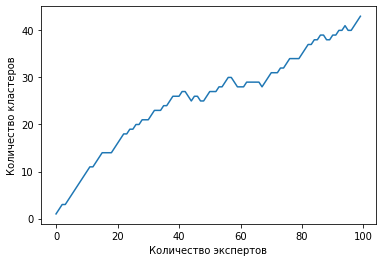

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(n_exp), n_cluster_list)
plt.xlabel('Количество экспертов')
plt.ylabel('Количество кластеров');

### Эксперты имеют определенные типы мнений

In [7]:
import itertools

n_clust = 5
permuts = list(itertools.permutations(range(n_obj)))
np.random.shuffle(permuts)
select_permuts = permuts[:n_clust]

In [8]:
landmarks = np.array([np.random.random() for _ in range(n_clust - 1)] + [1])
landmarks = np.sort(landmarks)

In [9]:
n_exp = 100
x = []
for _ in range(n_exp):
    p = np.random.random()
    i = (landmarks < p).sum()
    x_i = np.random.normal(select_permuts[i], .1)
    x.append(x_i)
    
x = np.array(x).T
#x = x.argsort(axis=0)

none_prob = 0.01
mask = np.random.binomial(1, none_prob, x.shape).astype(bool)
x[mask] = -1e3

#x = x.argsort(axis=0)
#x = x / x.max(axis=0, keepdims=True)

In [10]:
for j in range(x.shape[1]):
    x_col = x[:,j]
    mask = x_col > -1e3
    if np.sum(mask) > 1:
        x[mask, j] = x_col[mask].argsort() / (np.sum(mask) - 1)
    else:
        x[mask, j] = 0

In [11]:
x[x==-1e3] = -1

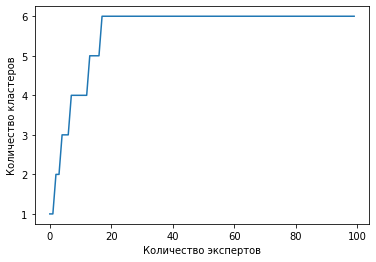

In [12]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

n_cluster_list = []
for n in range(100):
    x_n = x.T[:n+1] 
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(x_n)
    n_cluster = len(set(clustering.labels_))
    n_cluster_list.append(n_cluster)
    
plt.plot(range(100), n_cluster_list)
plt.xlabel('Количество экспертов')
plt.ylabel('Количество кластеров');

### Получение рейтинга

In [13]:
inp = '''4				9	5					3	9	7	6
2	6	4	8	7	4	3	3		4	6	3	4	2
5	1	5	5	4	3	8	4	2	3	5	5	6	
7	7	2	3	2	8	4	6	3	5		6	5	1
	2	7	2	6	7	5	5	7		7	7	8	
3	4	1	9	5		1	1	6	6	1	2	2	4
	3	3		1	2	6	2	1	1	2	8		5
6	5	8	4	8	1	7	7	4	7		1	1	
1	8	6	1	3	6	2	8	5	2	4	4	3	3'''
 
x = np.array([line.split('\t') for line in inp.split('\n')]).astype(object)
x[x!=''] = x[x!=''].astype(int)
x[x==''] = None

In [14]:
x

array([[4, None, None, None, 9, 5, None, None, None, None, 3, 9, 7, 6],
       [2, 6, 4, 8, 7, 4, 3, 3, None, 4, 6, 3, 4, 2],
       [5, 1, 5, 5, 4, 3, 8, 4, 2, 3, 5, 5, 6, None],
       [7, 7, 2, 3, 2, 8, 4, 6, 3, 5, None, 6, 5, 1],
       [None, 2, 7, 2, 6, 7, 5, 5, 7, None, 7, 7, 8, None],
       [3, 4, 1, 9, 5, None, 1, 1, 6, 6, 1, 2, 2, 4],
       [None, 3, 3, None, 1, 2, 6, 2, 1, 1, 2, 8, None, 5],
       [6, 5, 8, 4, 8, 1, 7, 7, 4, 7, None, 1, 1, None],
       [1, 8, 6, 1, 3, 6, 2, 8, 5, 2, 4, 4, 3, 3]], dtype=object)

In [15]:
def my_rating(x):
    for j in range(x.shape[1]):
        mask = x[:,j] != None
        if np.sum(mask) > 1:
            sort = np.sort(x[mask, j])
            temp = np.array([np.argmax((sort==i)) for i in x[mask, j]]) / (np.sum(mask) - 1)
            x[mask, j] = temp
        else:
            x[mask, j] = 0
    for i in range(x.shape[0]):
        mask = x[i] == None
        x[i,mask] = np.median(x[i,~mask])
    rating = x.sum(axis=1)
    return rating.argsort()

In [16]:
my_rating = my_rating(x)

In [17]:
product_names = np.array(['Устрицы',
                          'Арахиc соленый',
                          'Молоко  2,5%',
                          'Макароны',
                          'Овсяное молоко 3.2%',
                          'Шоколад',
                          'Сырок "РОСТАГРОЭКСПОРТ"',
                          'Кефир 3.2%',
                          'Гречневая крупа']
                        )
product_names[my_rating]

array(['Сырок "РОСТАГРОЭКСПОРТ"', 'Шоколад', 'Гречневая крупа',
       'Арахиc соленый', 'Молоко  2,5%', 'Макароны', 'Кефир 3.2%',
       'Овсяное молоко 3.2%', 'Устрицы'], dtype='<U23')

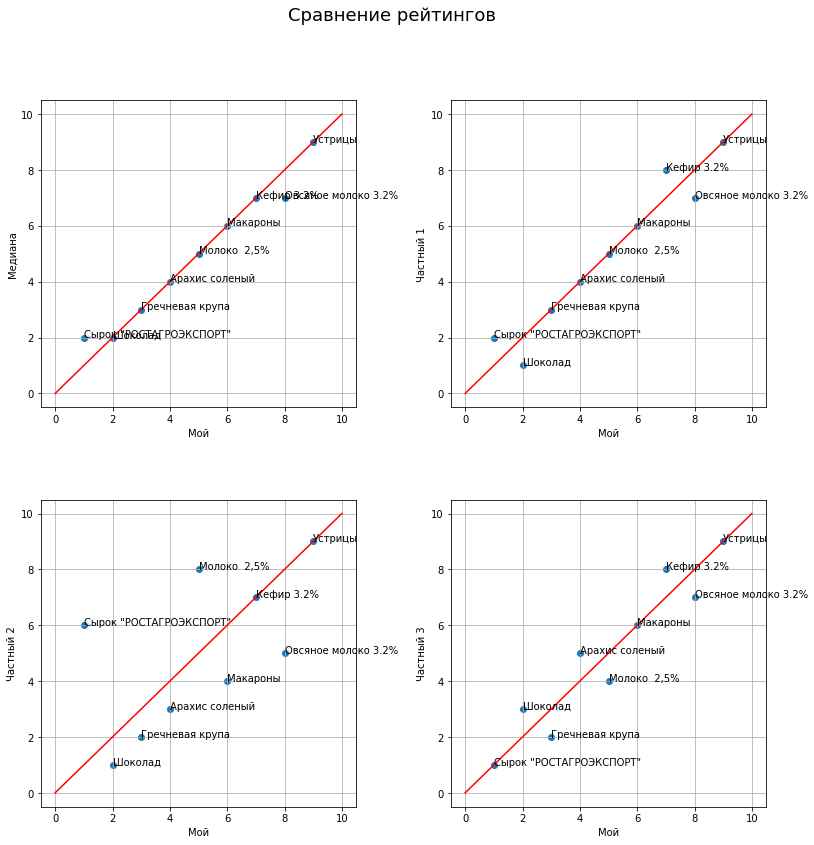

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(13, 13))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

my_rating = [9, 4, 5, 6, 8, 2, 1, 7, 3]
med_rating = [9, 4, 5, 6, 7, 2, 2, 7, 3]
mean_rating = [8.470588235, 4.705882353, 4.529411765, 5.294117647, 6.823529412, 2.470588235, 2.235294118, 6.588235294, 4.058823529]
rating1 = [9, 4, 5, 6, 7, 1, 2, 8, 3]
rating2 = [9, 3, 8, 4, 5, 1, 6, 7, 2]
rating3 = [9, 5, 4, 6, 7, 3, 1, 8, 2]

axs[0, 0].scatter(my_rating, med_rating)
axs[0, 0].plot([0, 10], [0, 10], c='r')
axs[0, 0].set_ylabel('Медиана')
axs[0, 0].set_xlabel('Мой')
axs[0, 0].grid(True)

axs[0, 1].scatter(my_rating, rating1)
axs[0, 1].plot([0, 10], [0, 10], c='r')
axs[0, 1].set_ylabel('Частный 1')
axs[0, 1].set_xlabel('Мой')
axs[0, 1].grid(True)

axs[1, 0].scatter(my_rating, rating2)
axs[1, 0].plot([0, 10], [0, 10], c='r')
axs[1, 0].set_ylabel('Частный 2')
axs[1, 0].set_xlabel('Мой')
axs[1, 0].grid(True)

axs[1, 1].scatter(my_rating, rating3)
axs[1, 1].plot([0, 10], [0, 10], c='r')
axs[1, 1].set_ylabel('Частный 3')
axs[1, 1].set_xlabel('Мой')
axs[1, 1].grid(True)

for i, txt in enumerate(product_names):
    axs[0, 0].annotate(txt, (my_rating[i], med_rating[i]))
    axs[0, 1].annotate(txt, (my_rating[i], rating1[i]))
    axs[1, 0].annotate(txt, (my_rating[i], rating2[i]))
    axs[1, 1].annotate(txt, (my_rating[i], rating3[i]))

fig.suptitle('Сравнение рейтингов', fontsize=18)
plt.show();